# PyTorch Neural Network Classification
[https://www.learnpytorch.io/02_pytorch_classification/](https://www.learnpytorch.io/02_pytorch_classification/)

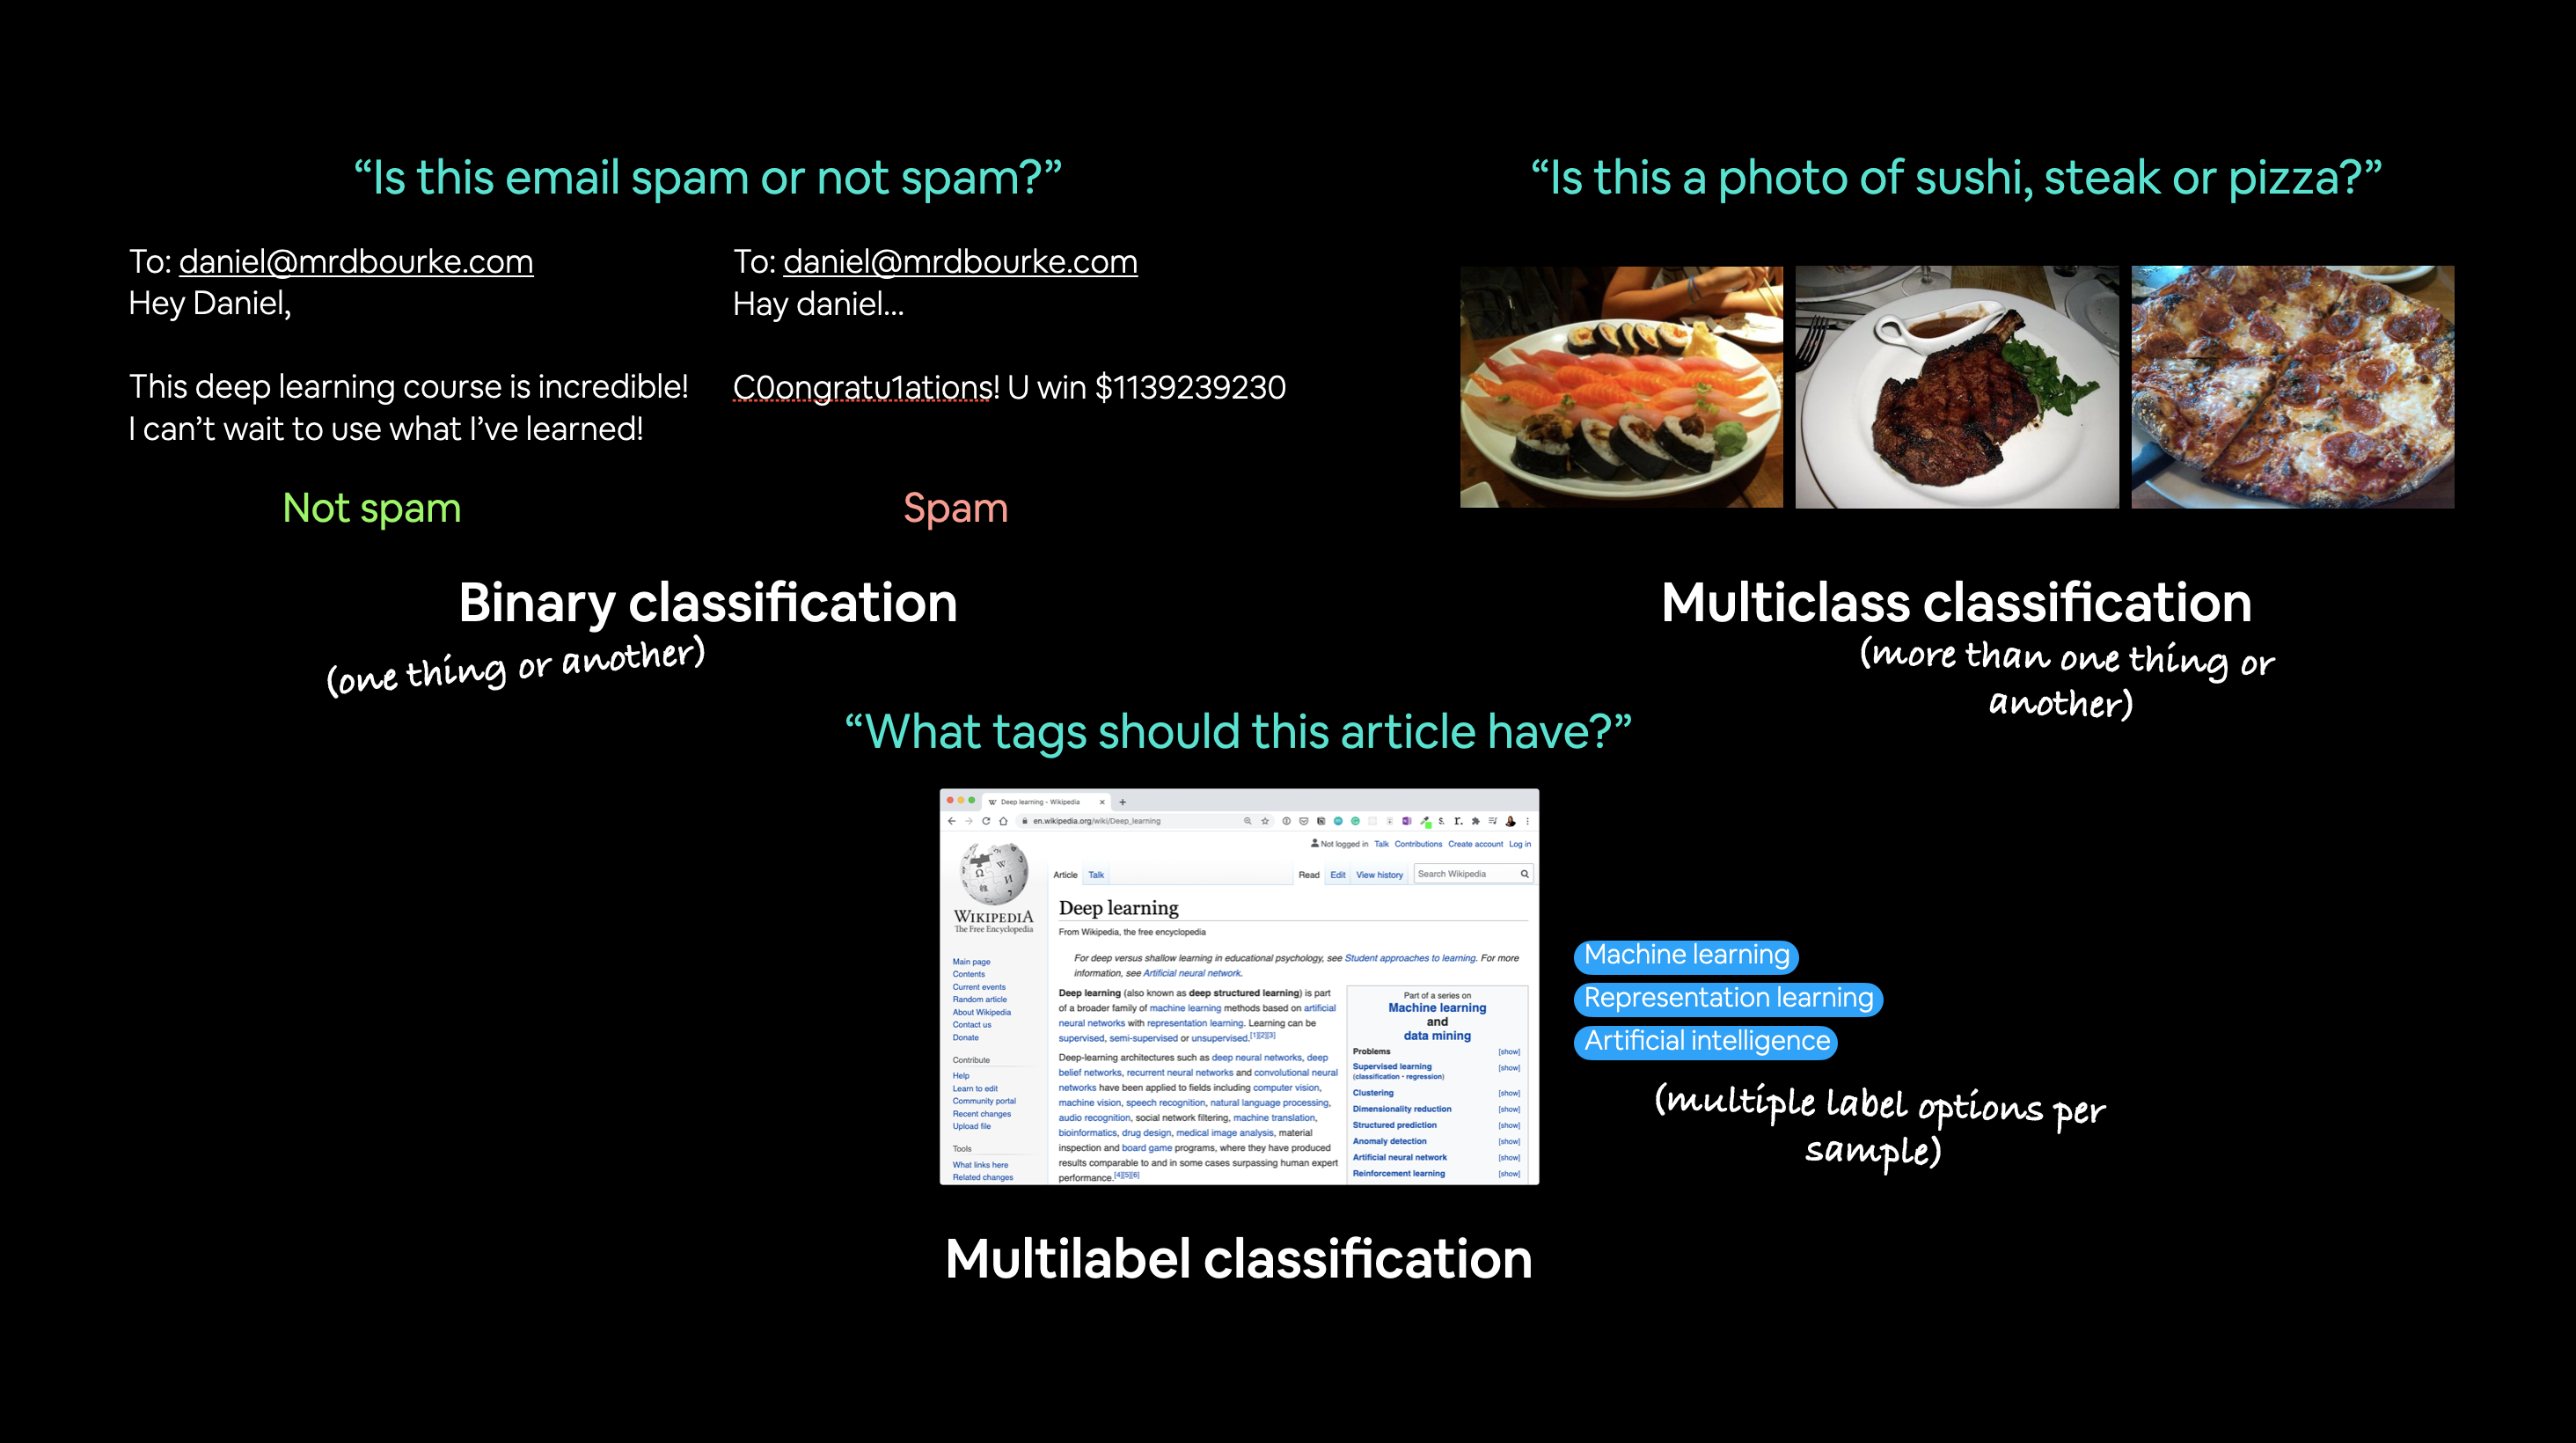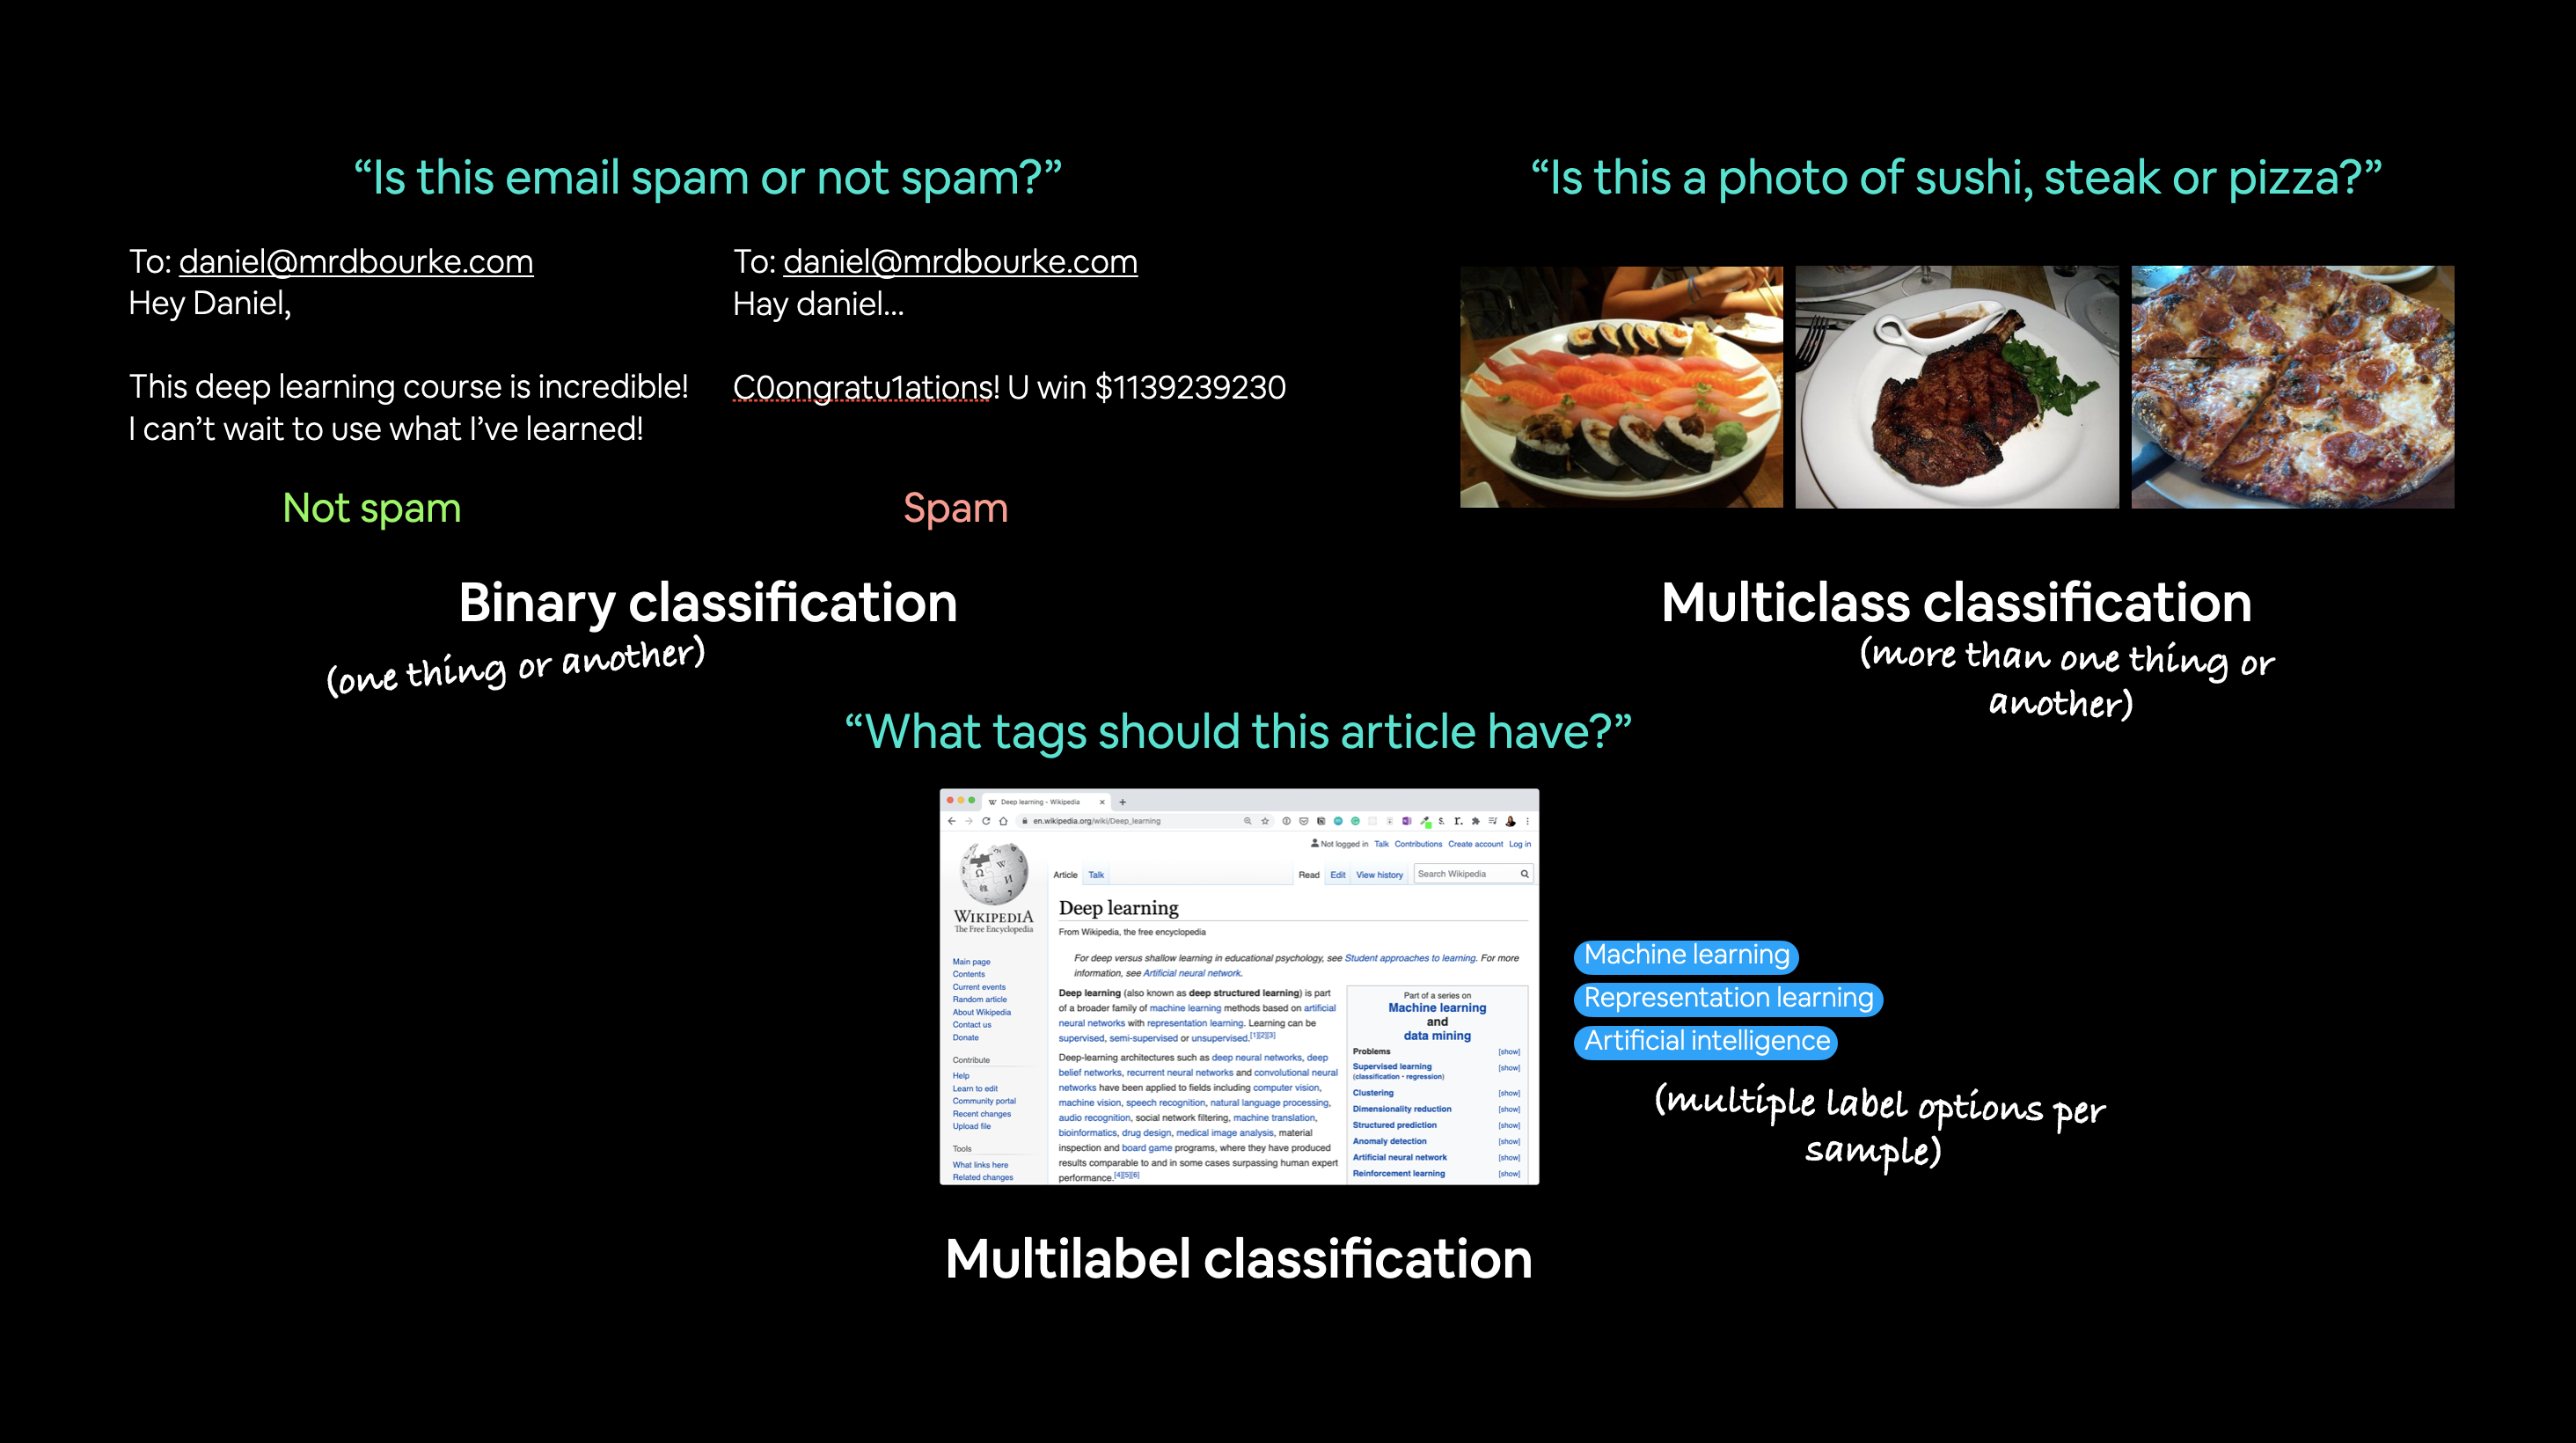

# Architecture of a classification neural network

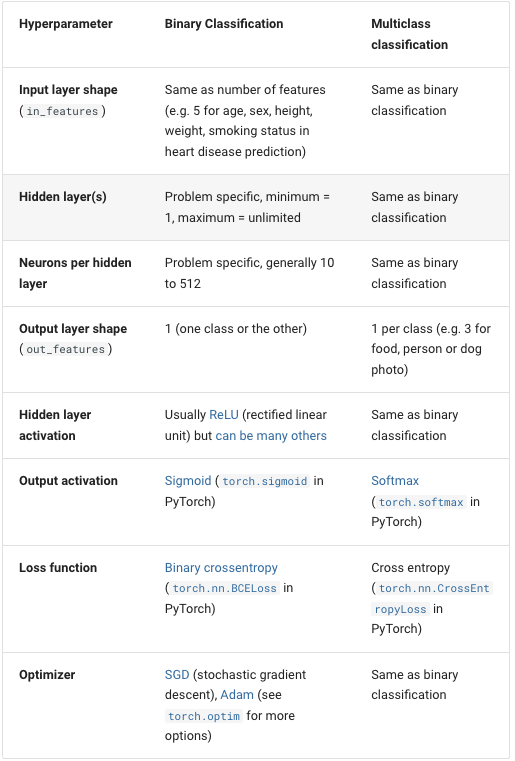

# 1. Make classification data and get it ready

In [2]:
from sklearn.datasets import make_circles

#Make 1000 samples
n_samples = 1000

X,y = make_circles(n_samples, noise = 0.03, random_state = 42)

In [3]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [5]:
# Make the Dataframe of the circle data
import pandas as pd
circles = pd.DataFrame({"X1":X[:,0],"X2":X[:,1],"label": y})

In [6]:
circles.head(10)

X1        X2  label
0  0.754246  0.231481      1
1 -0.756159  0.153259      1
2 -0.815392  0.173282      1
3 -0.393731  0.692883      1
4  0.442208 -0.896723      0
5 -0.479646  0.676435      1
6 -0.013648  0.803349      1
7  0.771513  0.147760      1
8 -0.169322 -0.793456      1
9 -0.121486  1.021509      0

In [7]:
# Check different labels
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

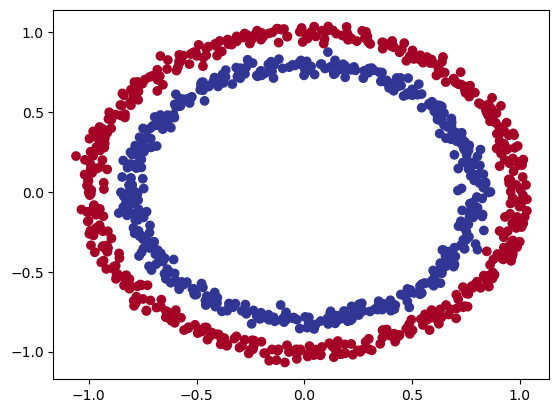

In [8]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

# Input and output shapes

In [9]:
# Check the shapes of the features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [10]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


# Turn the data into tensors and create train test splits

In [11]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [12]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

# 2. Building a model

In [13]:
import torch
from torch import nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [16]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features, produces 1 feature (y)
    
    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        return self.layer_2(self.layer_1(x)) # computation goes through layer_1 first then the output of layer_1 goes through layer_2

# 4. Create an instance of the model and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

nn.Sequential is fantastic for straight-forward computations, however, as the namespace says, it always runs in sequential order.

In [17]:
# Simple dode 
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[ 0.0021],
        [-0.0515],
        [ 0.2367],
        [-0.0647],
        [ 0.3858],
        [ 0.3519],
        [ 0.0827],
        [ 0.1776],
        [ 0.2300],
        [-0.0535]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


# Setup loss function and optimizer

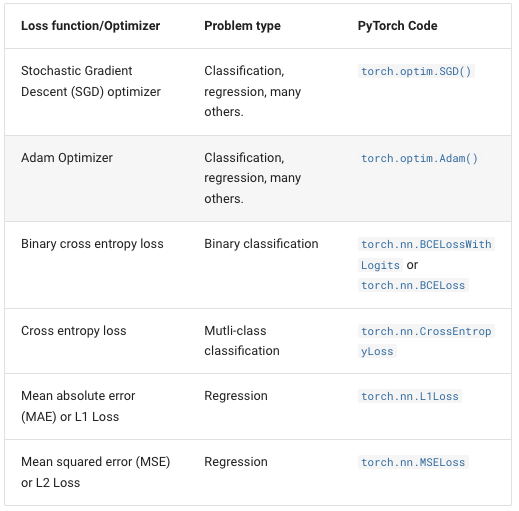

PyTorch has two binary cross entropy implementations:

torch.nn.BCELoss() - Creates a loss function that measures the binary cross entropy between the target (label) and input (features).
torch.nn.BCEWithLogitsLoss() - This is the same as above except it has a sigmoid layer (nn.Sigmoid) built-in (we'll see what this means soon).
Which one should you use?

The documentation for torch.nn.BCEWithLogitsLoss() states that it's more numerically stable than using torch.nn.BCELoss() after a nn.Sigmoid layer.



In [20]:
# Create a loos function
loss_fn = nn.BCEWithLogitsLoss() 

#Create a optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),lr = 0.1)

In [21]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred))*100
    return acc

# Train model


### Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediction labels)

In [22]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.0021],
        [-0.0515],
        [ 0.2367],
        [-0.0647],
        [ 0.3858]], device='cuda:0', grad_fn=<SliceBackward0>)

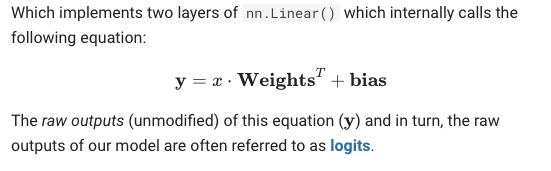

In [23]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5005],
        [0.4871],
        [0.5589],
        [0.4838],
        [0.5953]], device='cuda:0', grad_fn=<SigmoidBackward0>)

The closer to 0, the more the model thinks the sample belongs to class 0, the closer to 1, the more the model thinks the sample belongs to class 1.

More specificially:

If y_pred_probs >= 0.5, y=1 (class 1)
If y_pred_probs < 0.5, y=0 (class 0)

In [25]:
y_preds = torch.round(y_pred_probs)

# infull
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

#Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

y_preds.squeeze()


tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 0., 1., 0., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [26]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

# Building a training and testing loop

In [27]:
from tqdm import tqdm
torch.manual_seed(42)

# Put the data to the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [29]:
epochs = 1000

for epoch in tqdm(range(epochs)):
    model_0.train()
    
    # Forward pas
    y_logits = model_0(X_train).squeeze() # Squeeze to reduce extra 1 dêmntion
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    # 2. Calculate los.accuracy
    loss = loss_fn(y_logits, y_train)
    
    acc = accuracy_fn(y_true = y_train, y_pred = y_pred)
    
    # 3. Optimizer zẻo grad
    optimizer.zero_grad()
    
    # 4. Loss backwards
    loss.backward()
    
    # 5. Optimizer step
    optimizer.step()
    
    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # Calculate loss accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true = y_test, y_pred = test_pred)
    if epoch % 20 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")    
        

 22%|████████▎                             | 219/1000 [00:00<00:00, 1097.46it/s]

Epoch: 0 | Loss: 0.69451, Accuracy: 49.88% | Test loss: 0.69157, Test acc: 52.00%
Epoch: 20 | Loss: 0.69425, Accuracy: 49.38% | Test loss: 0.69168, Test acc: 52.00%
Epoch: 40 | Loss: 0.69405, Accuracy: 49.25% | Test loss: 0.69180, Test acc: 51.50%
Epoch: 60 | Loss: 0.69388, Accuracy: 49.12% | Test loss: 0.69192, Test acc: 51.50%
Epoch: 80 | Loss: 0.69375, Accuracy: 49.12% | Test loss: 0.69205, Test acc: 51.00%
Epoch: 100 | Loss: 0.69364, Accuracy: 49.00% | Test loss: 0.69219, Test acc: 51.00%
Epoch: 120 | Loss: 0.69354, Accuracy: 49.38% | Test loss: 0.69231, Test acc: 52.00%
Epoch: 140 | Loss: 0.69346, Accuracy: 49.12% | Test loss: 0.69244, Test acc: 52.50%
Epoch: 160 | Loss: 0.69339, Accuracy: 49.00% | Test loss: 0.69256, Test acc: 52.00%
Epoch: 180 | Loss: 0.69334, Accuracy: 49.00% | Test loss: 0.69268, Test acc: 51.50%
Epoch: 200 | Loss: 0.69329, Accuracy: 49.25% | Test loss: 0.69280, Test acc: 49.50%


 44%|████████████████▉                     | 445/1000 [00:00<00:00, 1112.09it/s]

Epoch: 220 | Loss: 0.69325, Accuracy: 49.00% | Test loss: 0.69291, Test acc: 50.50%
Epoch: 240 | Loss: 0.69321, Accuracy: 48.88% | Test loss: 0.69301, Test acc: 48.50%
Epoch: 260 | Loss: 0.69318, Accuracy: 50.25% | Test loss: 0.69311, Test acc: 46.00%
Epoch: 280 | Loss: 0.69315, Accuracy: 50.00% | Test loss: 0.69321, Test acc: 47.00%
Epoch: 300 | Loss: 0.69313, Accuracy: 49.25% | Test loss: 0.69330, Test acc: 49.00%
Epoch: 320 | Loss: 0.69311, Accuracy: 49.50% | Test loss: 0.69338, Test acc: 50.50%
Epoch: 340 | Loss: 0.69309, Accuracy: 49.88% | Test loss: 0.69346, Test acc: 48.00%
Epoch: 360 | Loss: 0.69308, Accuracy: 50.00% | Test loss: 0.69354, Test acc: 48.50%
Epoch: 380 | Loss: 0.69306, Accuracy: 50.25% | Test loss: 0.69361, Test acc: 48.00%
Epoch: 400 | Loss: 0.69305, Accuracy: 50.25% | Test loss: 0.69368, Test acc: 47.00%
Epoch: 420 | Loss: 0.69304, Accuracy: 50.75% | Test loss: 0.69374, Test acc: 46.00%
Epoch: 440 | Loss: 0.69303, Accuracy: 50.75% | Test loss: 0.69380, Test acc:

 67%|█████████████████████████▍            | 669/1000 [00:00<00:00, 1110.64it/s]

Epoch: 460 | Loss: 0.69303, Accuracy: 51.00% | Test loss: 0.69386, Test acc: 46.50%
Epoch: 480 | Loss: 0.69302, Accuracy: 50.38% | Test loss: 0.69391, Test acc: 47.00%
Epoch: 500 | Loss: 0.69302, Accuracy: 50.75% | Test loss: 0.69396, Test acc: 46.00%
Epoch: 520 | Loss: 0.69301, Accuracy: 50.75% | Test loss: 0.69401, Test acc: 45.50%
Epoch: 540 | Loss: 0.69301, Accuracy: 51.00% | Test loss: 0.69405, Test acc: 45.50%
Epoch: 560 | Loss: 0.69300, Accuracy: 50.88% | Test loss: 0.69409, Test acc: 46.50%
Epoch: 580 | Loss: 0.69300, Accuracy: 51.12% | Test loss: 0.69413, Test acc: 47.00%
Epoch: 600 | Loss: 0.69300, Accuracy: 51.62% | Test loss: 0.69417, Test acc: 46.50%
Epoch: 620 | Loss: 0.69299, Accuracy: 51.38% | Test loss: 0.69420, Test acc: 46.50%
Epoch: 640 | Loss: 0.69299, Accuracy: 51.25% | Test loss: 0.69424, Test acc: 46.00%
Epoch: 660 | Loss: 0.69299, Accuracy: 51.00% | Test loss: 0.69427, Test acc: 45.50%
Epoch: 680 | Loss: 0.69299, Accuracy: 51.00% | Test loss: 0.69429, Test acc:

 89%|█████████████████████████████████▉    | 893/1000 [00:00<00:00, 1110.54it/s]

Epoch: 700 | Loss: 0.69299, Accuracy: 51.25% | Test loss: 0.69432, Test acc: 45.50%
Epoch: 720 | Loss: 0.69299, Accuracy: 51.25% | Test loss: 0.69434, Test acc: 45.50%
Epoch: 740 | Loss: 0.69299, Accuracy: 51.25% | Test loss: 0.69437, Test acc: 45.50%
Epoch: 760 | Loss: 0.69299, Accuracy: 51.00% | Test loss: 0.69439, Test acc: 45.50%
Epoch: 780 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69441, Test acc: 45.50%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69443, Test acc: 45.50%
Epoch: 820 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69444, Test acc: 45.50%
Epoch: 840 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69446, Test acc: 45.50%
Epoch: 860 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69448, Test acc: 45.50%
Epoch: 880 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69449, Test acc: 45.50%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69450, Test acc: 45.50%
Epoch: 920 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69451, Test acc:

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1108.23it/s]

Epoch: 940 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69453, Test acc: 45.50%
Epoch: 960 | Loss: 0.69298, Accuracy: 51.25% | Test loss: 0.69454, Test acc: 45.50%
Epoch: 980 | Loss: 0.69298, Accuracy: 51.25% | Test loss: 0.69455, Test acc: 45.50%


# Make predictions and evaluate the model

In [30]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

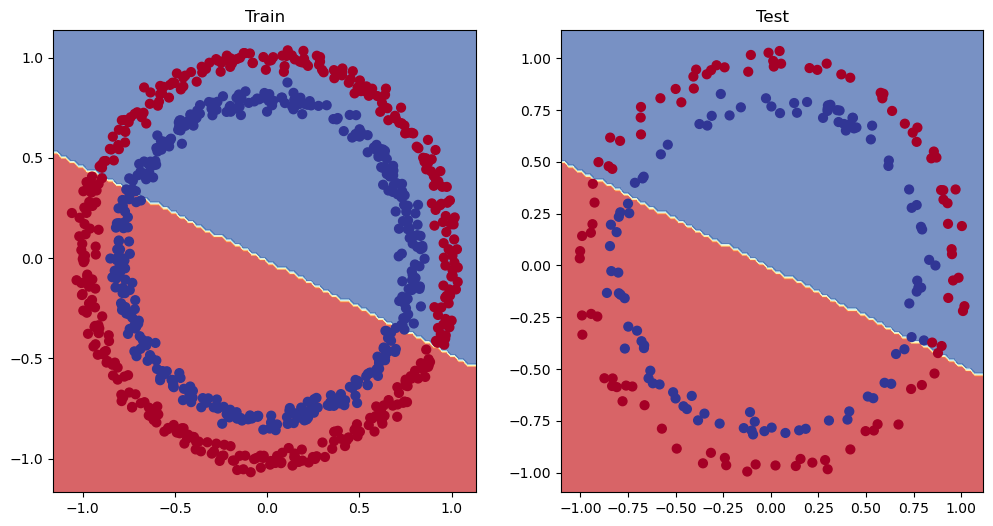

In [31]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

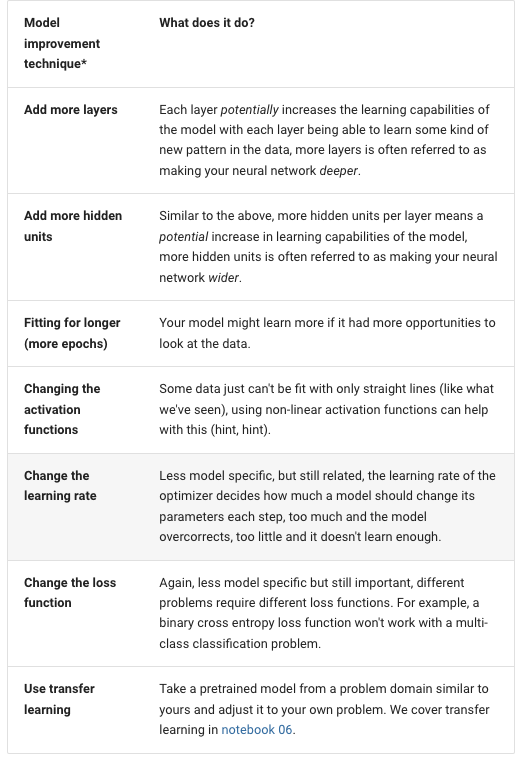

In [32]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x): # note: always make sure forward is spelt correctly!
        # Creating a model like this is the same as below, though below
        # generally benefits from speedups where possible.
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [33]:
# loss_fn = nn.BCELoss() # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [34]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in tqdm(range(epochs)):
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> predicition probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


 18%|██████▊                                | 175/1000 [00:00<00:00, 882.99it/s]

Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%


 36%|██████████████▏                        | 364/1000 [00:00<00:00, 923.54it/s]

Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00%


 55%|█████████████████████▌                 | 553/1000 [00:00<00:00, 934.02it/s]

Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%


 74%|████████████████████████████▉          | 743/1000 [00:00<00:00, 940.36it/s]

Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


 93%|████████████████████████████████████▍  | 934/1000 [00:01<00:00, 944.02it/s]

Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 929.88it/s]


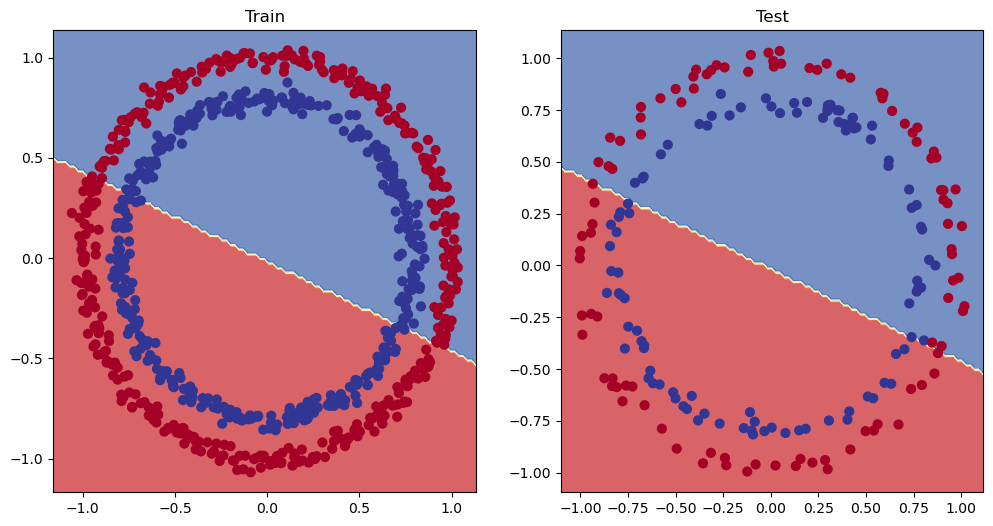

In [35]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

# Preparing data to see if our model can model a straight line

In [37]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [38]:

# Create train and test splits
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(len(X_train_regression), 
    len(y_train_regression), 
    len(X_test_regression), 
    len(y_test_regression))

80 80 20 20


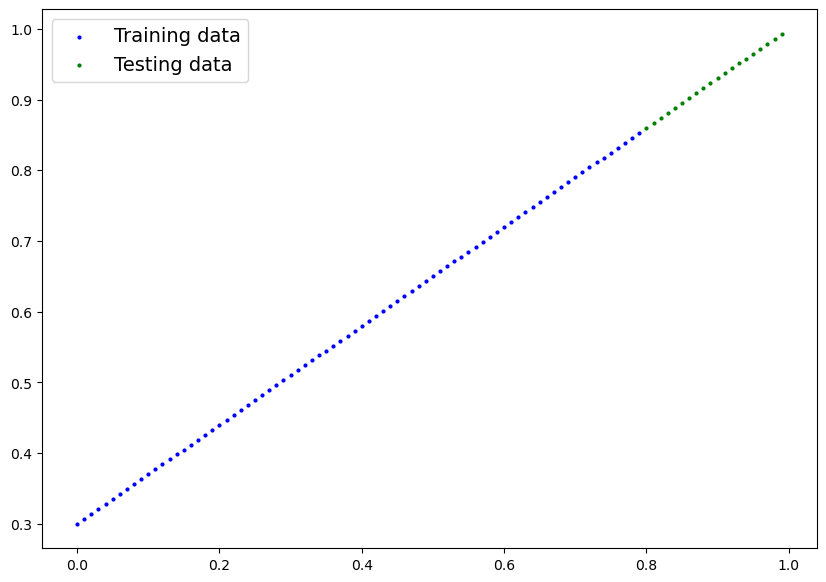

In [39]:

plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
);

In [36]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2


Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [40]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr = 0.1)

In [42]:
# Train the model 
torch.manual_seed(42)
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)


for epoch in tqdm(range(epochs)):
    ### Trainning 
    # 1. Forward pass
    y_pred = model_2(X_train_regression)
    
    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train_regression)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss nackwards
    loss.backward()
    
    # 5. Optimizer step
    optimizer.step()
    
    ### Testing
    model_2.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_pred = model_2(X_test_regression)
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test_regression)
    # Print out what's happening
    if epoch % 100 == 0: 
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

 24%|█████████                             | 238/1000 [00:00<00:00, 1188.97it/s]

Epoch: 0 | Train loss: 0.75986, Test loss: 0.54143
Epoch: 100 | Train loss: 0.09309, Test loss: 0.02901
Epoch: 200 | Train loss: 0.07376, Test loss: 0.02850


 48%|██████████████████▏                   | 477/1000 [00:00<00:00, 1188.77it/s]

Epoch: 300 | Train loss: 0.06745, Test loss: 0.00615
Epoch: 400 | Train loss: 0.06107, Test loss: 0.02004
Epoch: 500 | Train loss: 0.05698, Test loss: 0.01061


 84%|███████████████████████████████▋      | 835/1000 [00:00<00:00, 1186.23it/s]

Epoch: 600 | Train loss: 0.04857, Test loss: 0.01326
Epoch: 700 | Train loss: 0.06109, Test loss: 0.02127
Epoch: 800 | Train loss: 0.05599, Test loss: 0.01426


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1184.74it/s]

Epoch: 900 | Train loss: 0.05571, Test loss: 0.00603


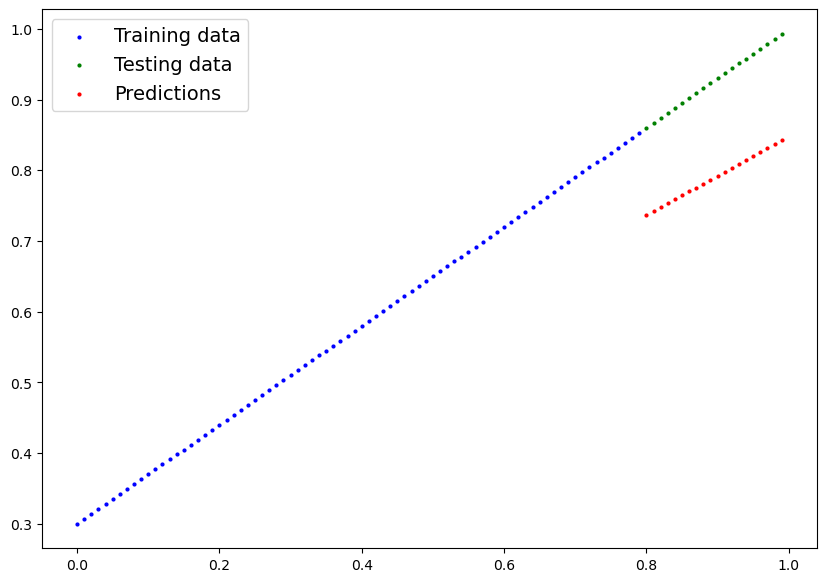

In [43]:

# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

A helpful troubleshooting step when building deep learning models is to start as small as possible to see if the model works before scaling it up.

This could mean starting with a simple neural network (not many layers, not many hidden neurons) and a small dataset (like the one we've made) and then overfitting (making the model perform too well) on that small example before increasing the amount data or the model size/design to reduce overfitting.



# The missing piece: non-linearity

## Recreating non-linear data (red and blue circles)


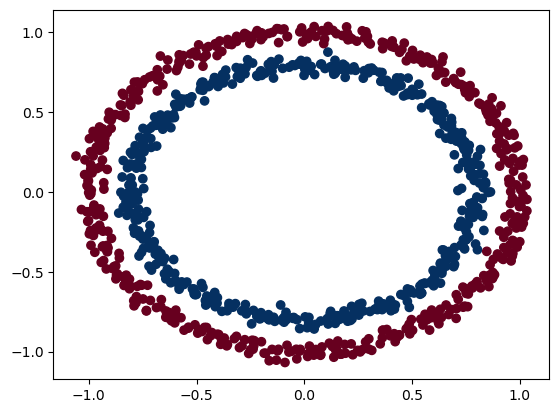

In [44]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [45]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

## Building a model with non-linearity

In [61]:
# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


In [83]:
# Building model with non-linear activation function 
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
        self.layer_3 = nn.Linear(in_features = 10, out_features = 1)
        self.relu = nn.ReLU() # Add in the ReLU activation function
        # Can also put sigmoid in the molde
        # self.sigmoid = nn.Sigmoid()
    def forward(self, x):
    # Intersperse the ReLU activation function between layers
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [84]:
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [85]:
# Set up loss and iptimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr = 0.1)

In [86]:
torch.manual_seed(42)
epochs = 1000

for epoch in tqdm(range(epochs)):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true = y_train, y_pred = y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss backward
    loss.backward()
    
    # 5. Optimizer step
    optimizer.step()
    
    ### Testing
    model_3.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_3(X_test).squeeze()
        test__pred = torch.round(torch.sigmoid(test_logits))
        # 2. Calculate loss and accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true = y_test, y_pred = test_pred)
        
        # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

  9%|███▌                                    | 89/1000 [00:00<00:01, 880.68it/s]

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 0.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 0.00%


 36%|█████████████▉                         | 356/1000 [00:00<00:00, 879.88it/s]

Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 0.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 0.00%


 53%|████████████████████▋                  | 532/1000 [00:00<00:00, 879.15it/s]

Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 0.00%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 0.00%


 71%|███████████████████████████▋           | 711/1000 [00:00<00:00, 886.36it/s]

Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 0.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 0.00%


 98%|██████████████████████████████████████▏| 979/1000 [00:01<00:00, 888.56it/s]

Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 0.00%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 0.00%


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 882.87it/s]


# Evaluating a model trained with non-linear activation functions

In [87]:
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

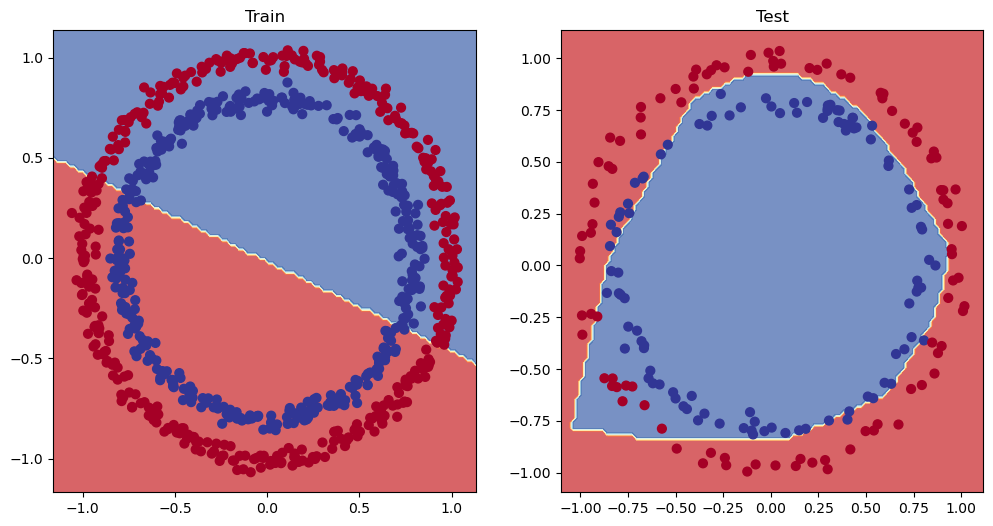

In [88]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

# Replicating non-linear activation functions

In [89]:
# Create a toy tensor (similar to the data going into our model(s))
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

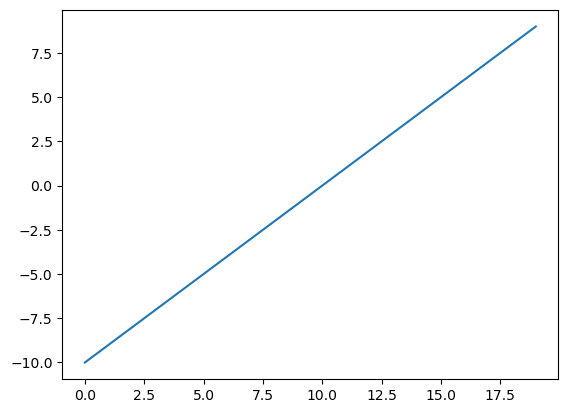

In [90]:

# Visualize the toy tensor
plt.plot(A);

In [91]:
# Create ReLU function by hand 
def relu(x):
  return torch.maximum(torch.tensor(0), x) # inputs must be tensors

# Pass toy tensor through ReLU function
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

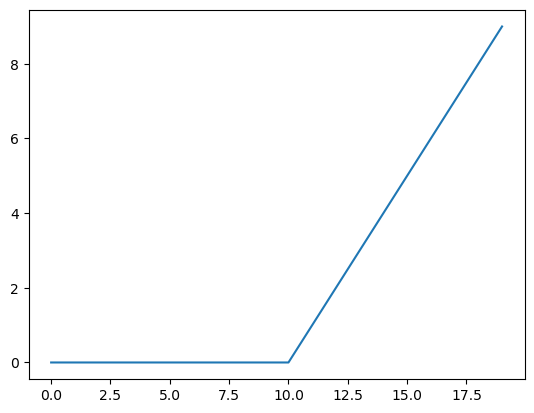

In [92]:
# Plot ReLU activated toy tensor
plt.plot(relu(A));

In [93]:
# Create a custom sigmoid function
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

# Test custom sigmoid on toy tensor
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

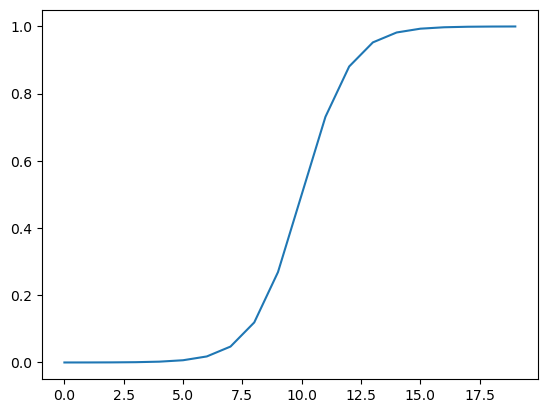

In [94]:
# Plot sigmoid activated toy tensor
plt.plot(sigmoid(A));

# Putting things together by building a multi-class PyTorch model

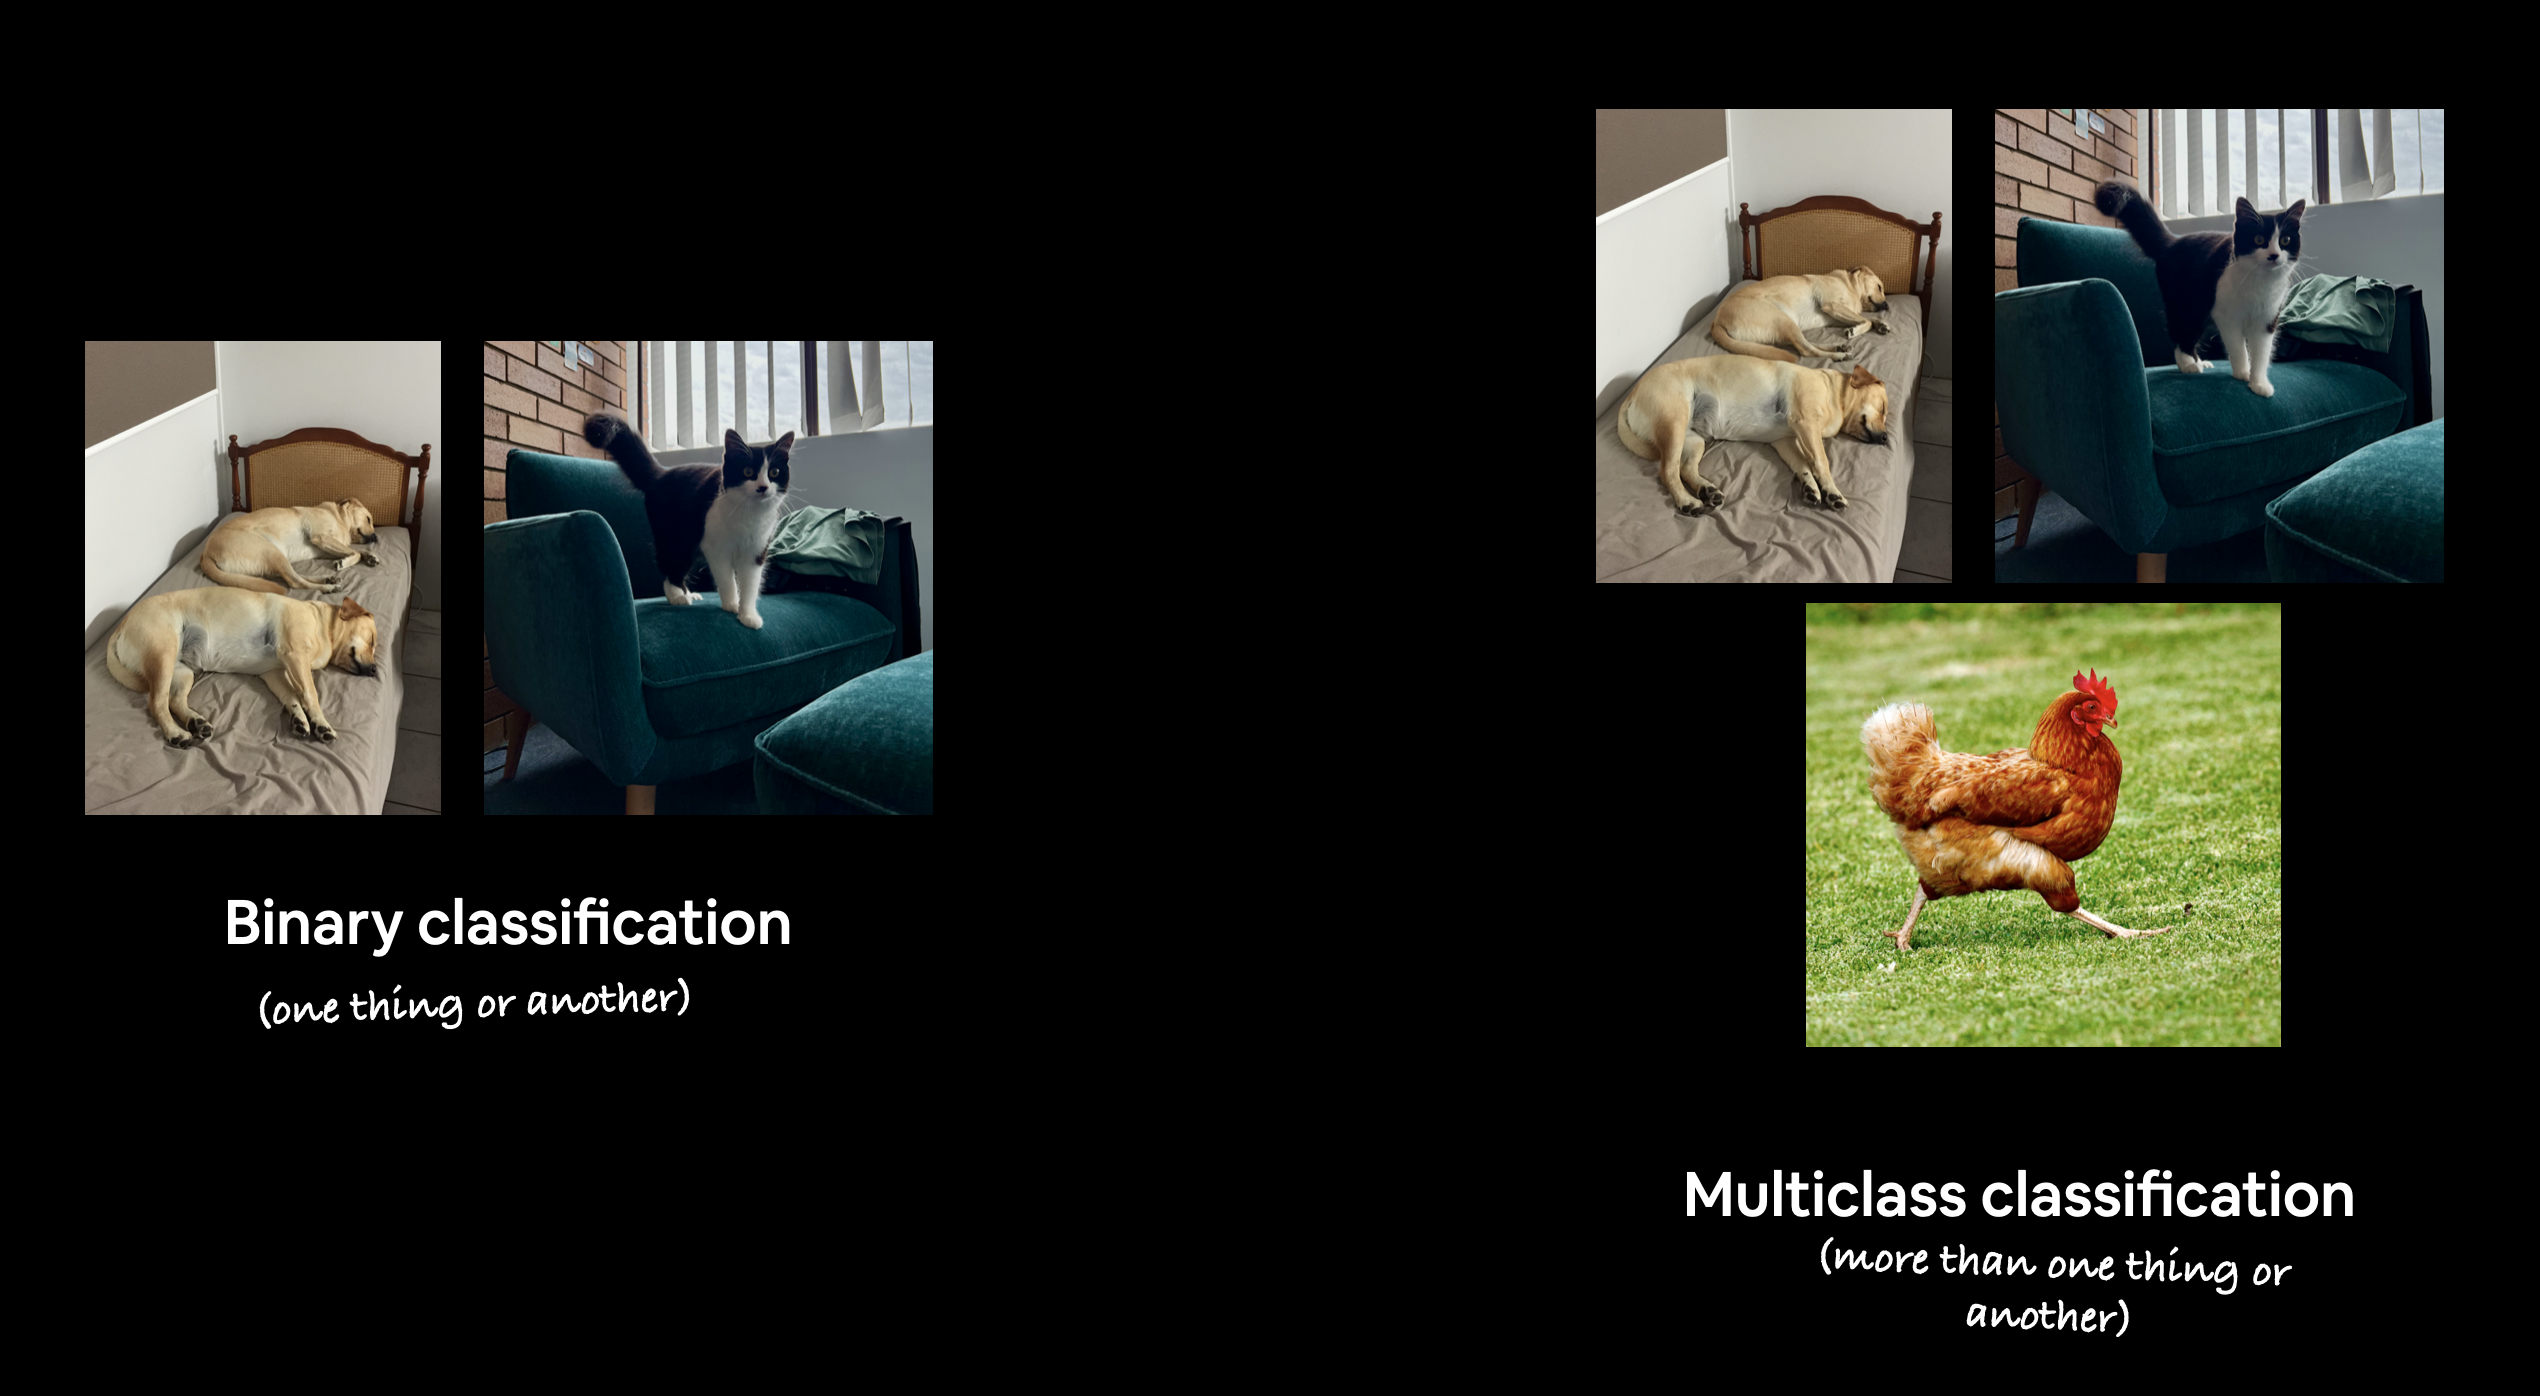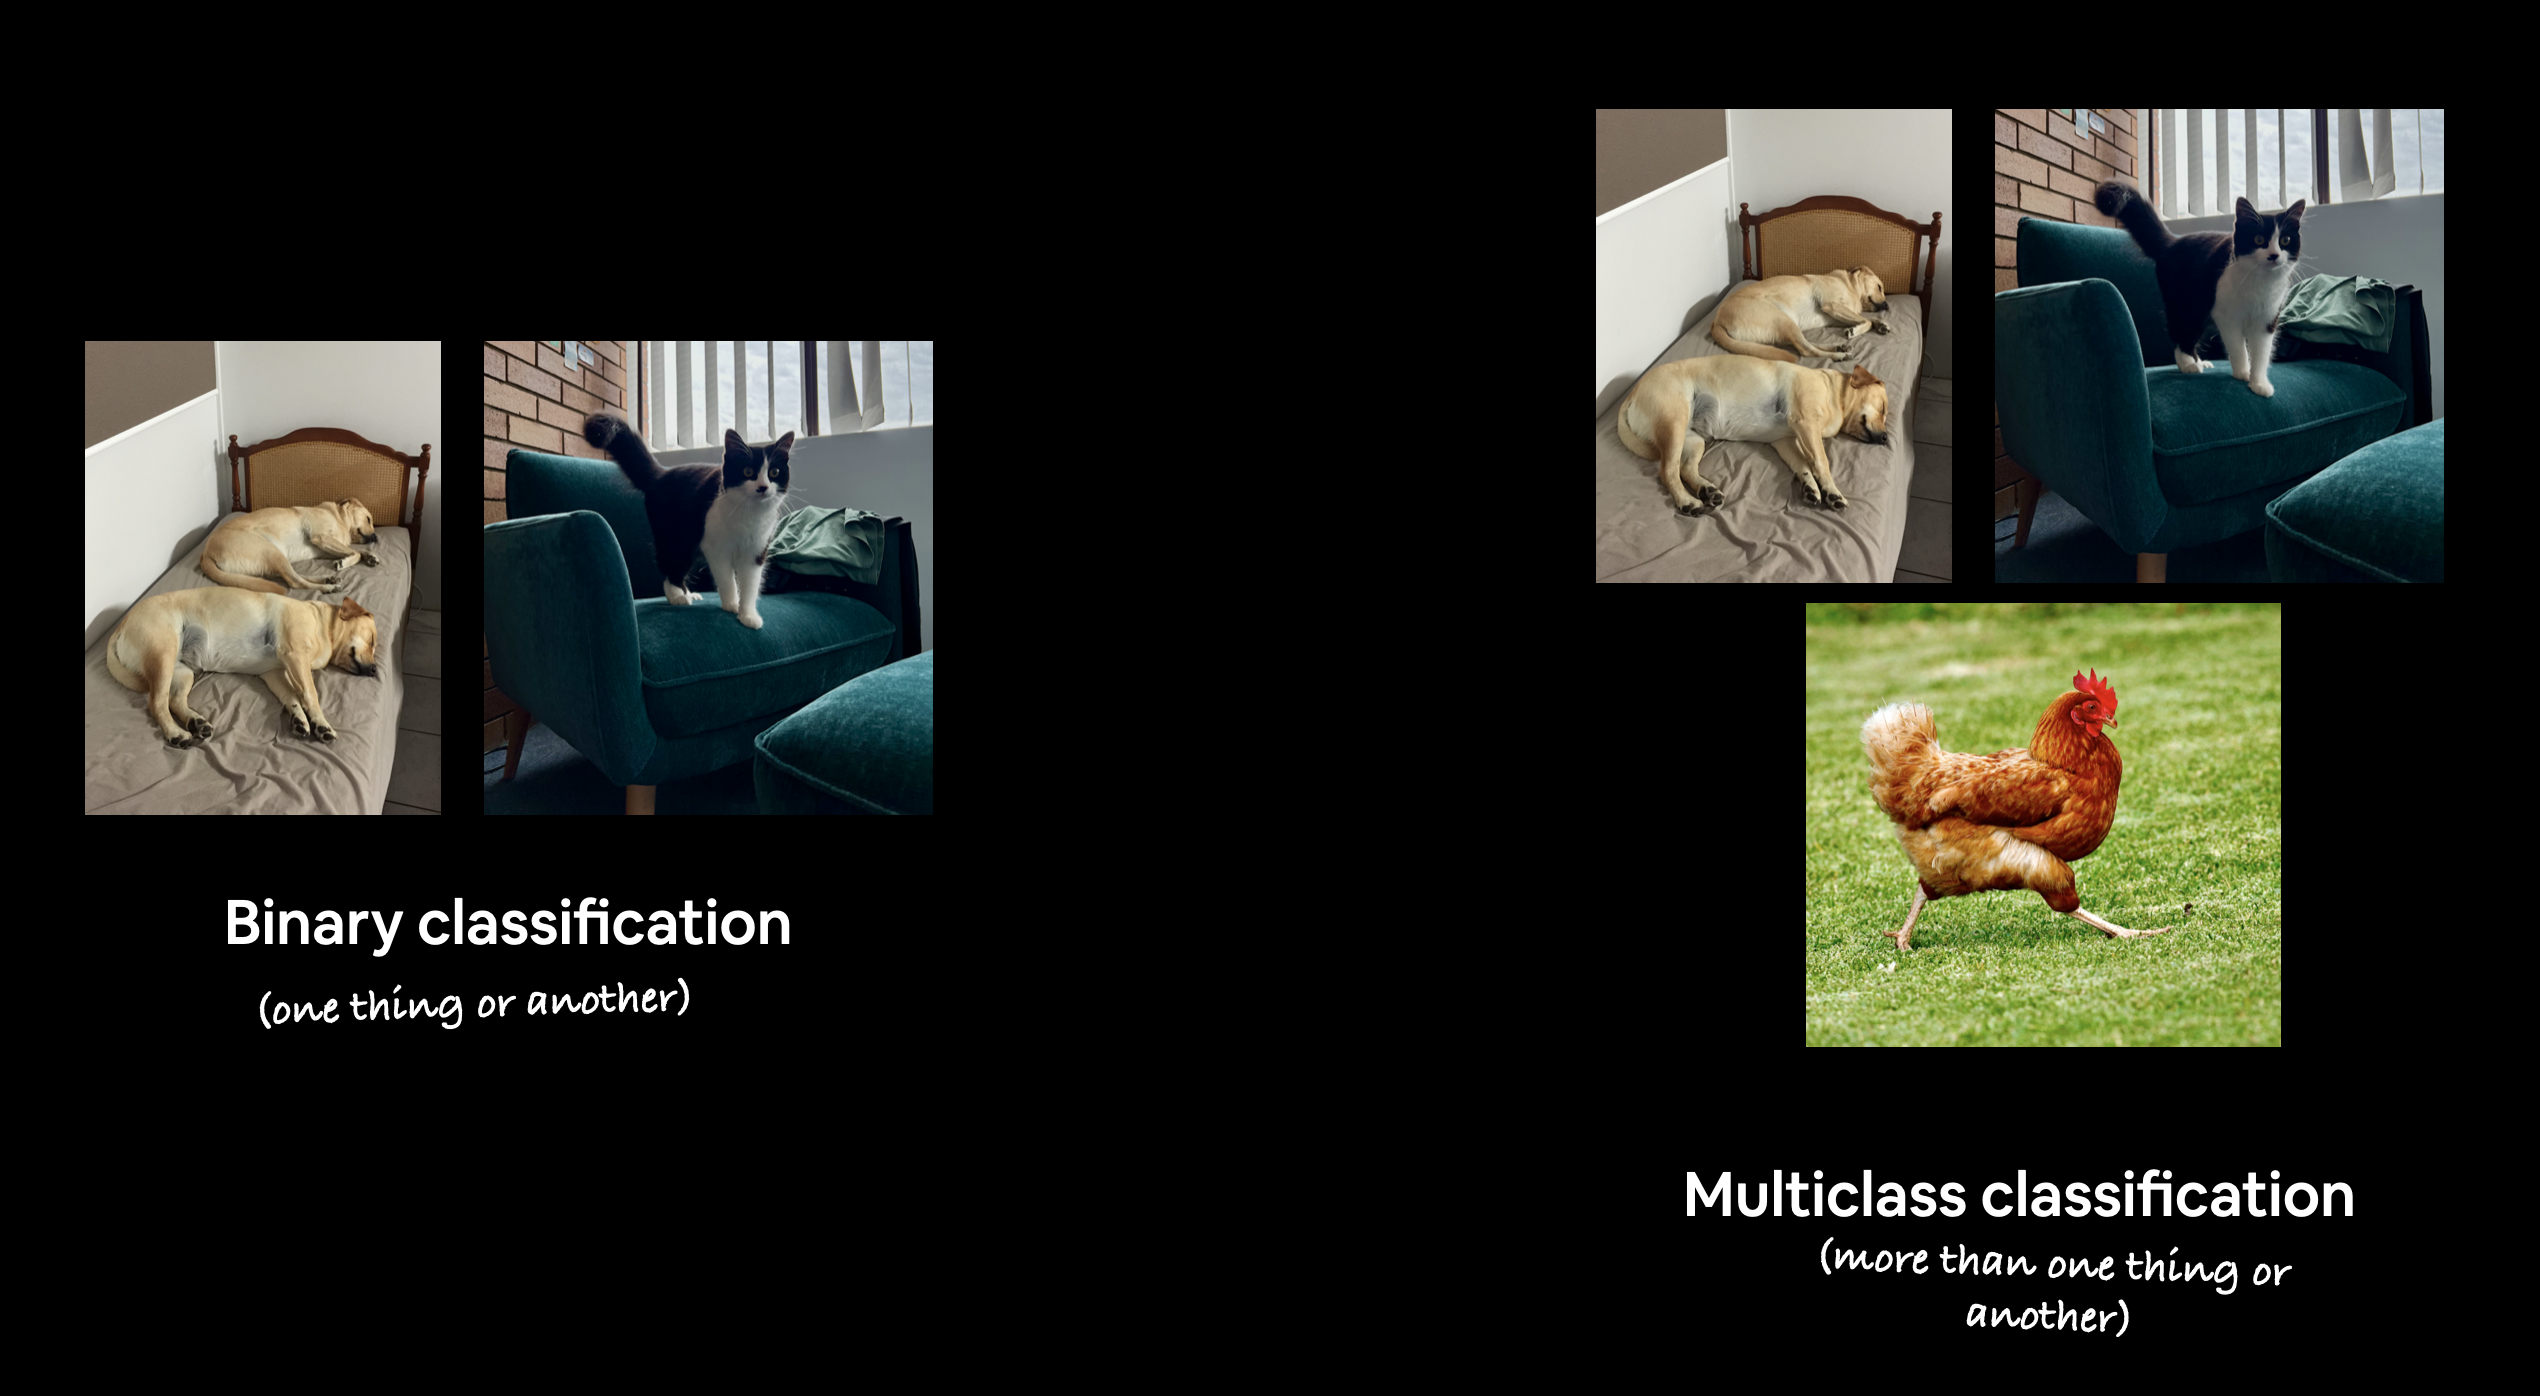

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


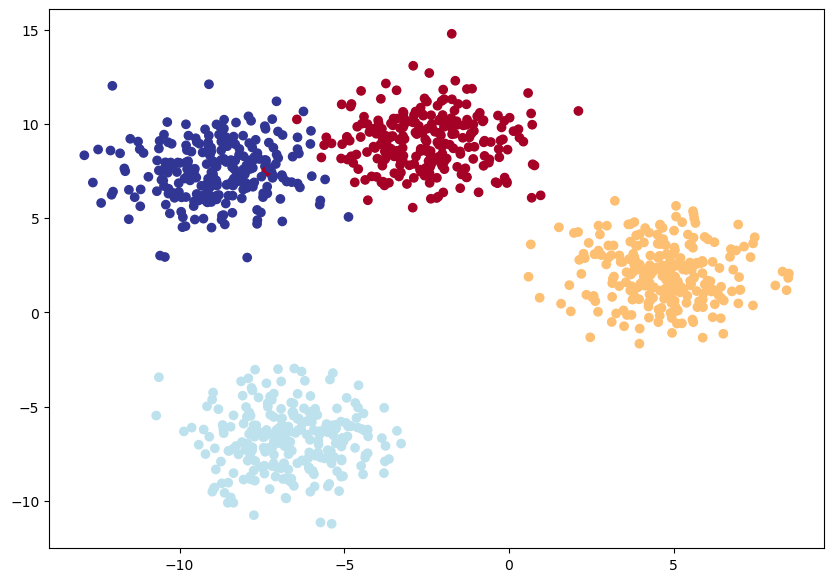

In [95]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

## Building a multi-class classification model in PyTorch

In [96]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [99]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units = 8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features = input_features, out_features = hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features = hidden_units, out_features = hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features = hidden_units, out_features = output_features))
    def forward(self, x):
            return self.linear_layer_stack(x)
                      

In [100]:
# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [101]:
# Create a loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr = 0.1)

In [102]:

# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [103]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES 

(torch.Size([4]), 4)

In [104]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [105]:

# Sum the first sample output of the softmax activation function 
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [106]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1872, 0.2918, 0.1495, 0.3715], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(3, device='cuda:0')



You can see the output of torch.argmax() returns 3, so for the features (X) of the sample at index 0, the model is predicting that the most likely class value (y) is 3.

Of course, right now this is just random guessing so it's got a 25% chance of being right (since there's four classes). But we can improve those chances by training the model.

# Creating a training and testing loop for a multi-class PyTorch model

In [107]:
# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)


In [109]:

# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 1000

for epoch in tqdm(range(epochs)):
    ### Trainning
    model_4.train()
    
    # 1. Forward pass
    y_logits = model_4(X_blob_train) # Raw logit
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)# go from logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    accuracy = accuracy_fn(y_true = y_blob_train, y_pred = y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss backwards
    loss.backward()
    
    # 5. Optimzier step
    optimizer.step()
    
    ## Testing
    model_4.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_4(X_blob_test)
        test_y_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        # 2. Calc loss and accuracy
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true = y_blob_test, y_pred = test_pred)
        
        # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

 21%|████████                              | 212/1000 [00:00<00:00, 1054.89it/s]

Epoch: 0 | Loss: 0.57519, Acc: 87.62% | Test Loss: 0.42672, Test Acc: 0.00%
Epoch: 10 | Loss: 0.13289, Acc: 87.62% | Test Loss: 0.12048, Test Acc: 0.00%
Epoch: 20 | Loss: 0.07753, Acc: 87.62% | Test Loss: 0.06920, Test Acc: 0.00%
Epoch: 30 | Loss: 0.05788, Acc: 87.62% | Test Loss: 0.04999, Test Acc: 0.00%
Epoch: 40 | Loss: 0.04818, Acc: 87.62% | Test Loss: 0.04023, Test Acc: 0.00%
Epoch: 50 | Loss: 0.04249, Acc: 87.62% | Test Loss: 0.03438, Test Acc: 0.00%
Epoch: 60 | Loss: 0.03879, Acc: 87.62% | Test Loss: 0.03051, Test Acc: 0.00%
Epoch: 70 | Loss: 0.03621, Acc: 87.62% | Test Loss: 0.02775, Test Acc: 0.00%
Epoch: 80 | Loss: 0.03431, Acc: 87.62% | Test Loss: 0.02569, Test Acc: 0.00%
Epoch: 90 | Loss: 0.03287, Acc: 87.62% | Test Loss: 0.02409, Test Acc: 0.00%
Epoch: 100 | Loss: 0.03175, Acc: 87.62% | Test Loss: 0.02281, Test Acc: 0.00%
Epoch: 110 | Loss: 0.03084, Acc: 87.62% | Test Loss: 0.02176, Test Acc: 0.00%
Epoch: 120 | Loss: 0.03010, Acc: 87.62% | Test Loss: 0.02089, Test Acc: 0.0

 42%|████████████████▏                     | 425/1000 [00:00<00:00, 1049.50it/s]

Epoch: 220 | Loss: 0.02665, Acc: 87.62% | Test Loss: 0.01647, Test Acc: 0.00%
Epoch: 230 | Loss: 0.02649, Acc: 87.62% | Test Loss: 0.01623, Test Acc: 0.00%
Epoch: 240 | Loss: 0.02633, Acc: 87.62% | Test Loss: 0.01601, Test Acc: 0.00%
Epoch: 250 | Loss: 0.02619, Acc: 87.62% | Test Loss: 0.01580, Test Acc: 0.00%
Epoch: 260 | Loss: 0.02606, Acc: 87.62% | Test Loss: 0.01562, Test Acc: 0.00%
Epoch: 270 | Loss: 0.02595, Acc: 87.62% | Test Loss: 0.01544, Test Acc: 0.00%
Epoch: 280 | Loss: 0.02583, Acc: 87.62% | Test Loss: 0.01528, Test Acc: 0.00%
Epoch: 290 | Loss: 0.02573, Acc: 87.62% | Test Loss: 0.01512, Test Acc: 0.00%
Epoch: 300 | Loss: 0.02564, Acc: 87.62% | Test Loss: 0.01498, Test Acc: 0.00%
Epoch: 310 | Loss: 0.02554, Acc: 87.62% | Test Loss: 0.01484, Test Acc: 0.00%
Epoch: 320 | Loss: 0.02546, Acc: 87.62% | Test Loss: 0.01471, Test Acc: 0.00%
Epoch: 330 | Loss: 0.02538, Acc: 87.62% | Test Loss: 0.01459, Test Acc: 0.00%
Epoch: 340 | Loss: 0.02530, Acc: 87.62% | Test Loss: 0.01447, Te

 64%|████████████████████████▏             | 637/1000 [00:00<00:00, 1054.49it/s]

Epoch: 430 | Loss: 0.02476, Acc: 87.62% | Test Loss: 0.01364, Test Acc: 0.00%
Epoch: 440 | Loss: 0.02471, Acc: 87.62% | Test Loss: 0.01357, Test Acc: 0.00%
Epoch: 450 | Loss: 0.02466, Acc: 87.62% | Test Loss: 0.01350, Test Acc: 0.00%
Epoch: 460 | Loss: 0.02461, Acc: 87.62% | Test Loss: 0.01343, Test Acc: 0.00%
Epoch: 470 | Loss: 0.02457, Acc: 87.62% | Test Loss: 0.01336, Test Acc: 0.00%
Epoch: 480 | Loss: 0.02452, Acc: 87.62% | Test Loss: 0.01329, Test Acc: 0.00%
Epoch: 490 | Loss: 0.02448, Acc: 87.62% | Test Loss: 0.01323, Test Acc: 0.00%
Epoch: 500 | Loss: 0.02444, Acc: 87.62% | Test Loss: 0.01317, Test Acc: 0.00%
Epoch: 510 | Loss: 0.02440, Acc: 87.62% | Test Loss: 0.01311, Test Acc: 0.00%
Epoch: 520 | Loss: 0.02436, Acc: 87.62% | Test Loss: 0.01306, Test Acc: 0.00%
Epoch: 530 | Loss: 0.02432, Acc: 87.62% | Test Loss: 0.01300, Test Acc: 0.00%
Epoch: 540 | Loss: 0.02428, Acc: 87.62% | Test Loss: 0.01295, Test Acc: 0.00%
Epoch: 550 | Loss: 0.02425, Acc: 87.62% | Test Loss: 0.01289, Te

 85%|████████████████████████████████▎     | 849/1000 [00:00<00:00, 1053.94it/s]

Epoch: 650 | Loss: 0.02391, Acc: 87.62% | Test Loss: 0.01243, Test Acc: 0.00%
Epoch: 660 | Loss: 0.02388, Acc: 87.62% | Test Loss: 0.01239, Test Acc: 0.00%
Epoch: 670 | Loss: 0.02385, Acc: 87.62% | Test Loss: 0.01235, Test Acc: 0.00%
Epoch: 680 | Loss: 0.02382, Acc: 87.62% | Test Loss: 0.01231, Test Acc: 0.00%
Epoch: 690 | Loss: 0.02379, Acc: 87.62% | Test Loss: 0.01227, Test Acc: 0.00%
Epoch: 700 | Loss: 0.02376, Acc: 87.62% | Test Loss: 0.01224, Test Acc: 0.00%
Epoch: 710 | Loss: 0.02373, Acc: 87.62% | Test Loss: 0.01220, Test Acc: 0.00%
Epoch: 720 | Loss: 0.02371, Acc: 87.62% | Test Loss: 0.01216, Test Acc: 0.00%
Epoch: 730 | Loss: 0.02368, Acc: 87.62% | Test Loss: 0.01213, Test Acc: 0.00%
Epoch: 740 | Loss: 0.02365, Acc: 87.62% | Test Loss: 0.01209, Test Acc: 0.00%
Epoch: 750 | Loss: 0.02362, Acc: 87.62% | Test Loss: 0.01206, Test Acc: 0.00%
Epoch: 760 | Loss: 0.02360, Acc: 87.62% | Test Loss: 0.01202, Test Acc: 0.00%
Epoch: 770 | Loss: 0.02357, Acc: 87.62% | Test Loss: 0.01199, Te

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1051.69it/s]

Epoch: 870 | Loss: 0.02332, Acc: 87.62% | Test Loss: 0.01168, Test Acc: 0.00%
Epoch: 880 | Loss: 0.02329, Acc: 87.62% | Test Loss: 0.01165, Test Acc: 0.00%
Epoch: 890 | Loss: 0.02327, Acc: 87.62% | Test Loss: 0.01162, Test Acc: 0.00%
Epoch: 900 | Loss: 0.02325, Acc: 87.62% | Test Loss: 0.01160, Test Acc: 0.00%
Epoch: 910 | Loss: 0.02322, Acc: 87.62% | Test Loss: 0.01157, Test Acc: 0.00%
Epoch: 920 | Loss: 0.02320, Acc: 87.62% | Test Loss: 0.01154, Test Acc: 0.00%
Epoch: 930 | Loss: 0.02318, Acc: 87.62% | Test Loss: 0.01151, Test Acc: 0.00%
Epoch: 940 | Loss: 0.02315, Acc: 87.62% | Test Loss: 0.01149, Test Acc: 0.00%
Epoch: 950 | Loss: 0.02313, Acc: 87.62% | Test Loss: 0.01146, Test Acc: 0.00%
Epoch: 960 | Loss: 0.02311, Acc: 87.62% | Test Loss: 0.01143, Test Acc: 0.00%
Epoch: 970 | Loss: 0.02309, Acc: 87.62% | Test Loss: 0.01141, Test Acc: 0.00%
Epoch: 980 | Loss: 0.02306, Acc: 87.62% | Test Loss: 0.01138, Test Acc: 0.00%
Epoch: 990 | Loss: 0.02304, Acc: 87.62% | Test Loss: 0.01136, Te

# Making and evaluating predictions with a PyTorch multi-class model

In [112]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  6.1114,  18.9144, -22.9658, -14.7009],
        [  9.5692, -23.8566,   5.8421,  17.7056],
        [ -8.4022, -21.8548,  30.5481,  17.0851],
        [  2.1334,  14.6692, -13.7849, -11.2670],
        [ 13.2158,   3.9333, -21.4969,  -3.6466],
        [ 10.8427, -29.6286,   8.5495,  22.0384],
        [ -9.3845, -15.7083,  27.1184,  12.4525],
        [ 11.9295,  -3.3310, -13.8632,   1.9516],
        [ -7.8675, -31.8228,  37.6588,  24.6513],
        [ 12.1850,  -0.6241, -16.3804,  -0.1232]], device='cuda:0')

In [113]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%


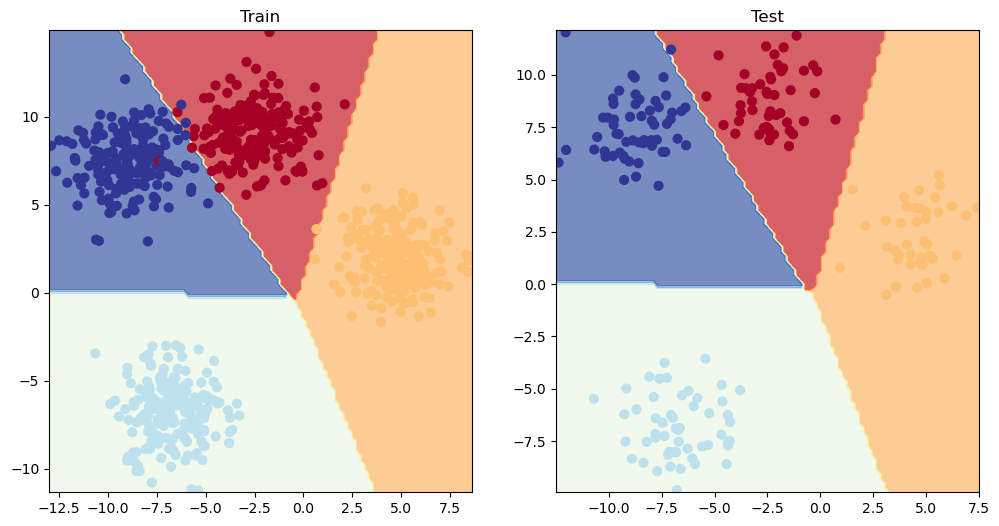

In [114]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

# More classification evaluation metrics

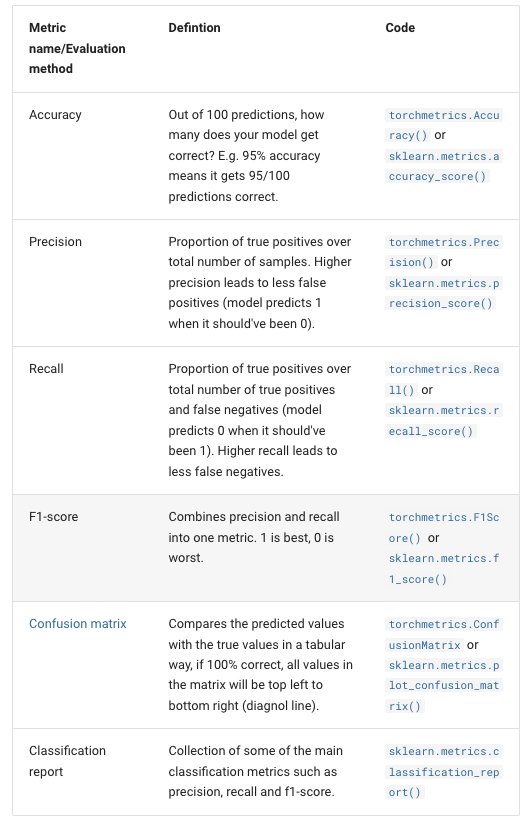

Scikit-Learn (a popular and world-class machine learning library) has many implementations of the above metrics and you're looking for a PyTorch-like version, check out TorchMetrics, especially the TorchMetrics classification section.

In [115]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

/bin/bash: /home/nhat/miniconda3/envs/test/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.6/419.6 kB 2.9 MB/s eta 0:00:002.7 MB/s eta 0:00:01


tensor(0.9950, device='cuda:0')